In [ ]:
!apt-get install -y fonts-nanum
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import font_manager
import seaborn as sns
import os
import folium
from folium.plugins import HeatMap
from folium import Choropleth
import geopandas as gpd
import json
import shapefile
from shapely.geometry import Polygon
from branca.colormap import linear


pd.set_option('display.max_columns',100)

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

<Axes: title={'center': '한글 테스트'}>

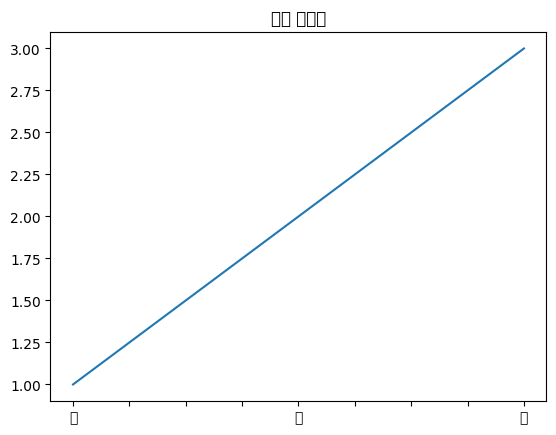

In [ ]:
# 간단한 예제 그래프를 그립니다.

# 예제 데이터를 생성합니다.
import pandas as pd
s = pd.Series([1, 2, 3], index=['가', '나', '다'])

# 그래프를 그립니다.
s.plot(title='한글 테스트')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 서울 지도 초기화
seoul = folium.Map(location=[37.55, 126.98], zoom_start=11)

# GeoJSON 파일 로드
geo_path = '/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/수연/서울_geojson.geojson'
geo_data = json.load(open(geo_path, encoding='utf-8'))

In [ ]:
folium.GeoJson(
    geo_data,
    name='서울 동별 경계',
    style_function=lambda feature: {
        'fillColor': 'transparent',  # 채우기 색상은 투명
        'color': 'green',  # 경계선 색상 초록
        'weight': 1.4,  # 선 굵기
        'opacity': 1  # 선의 불투명도
    }
).add_to(seoul)

# 결과 지도 출력
seoul


In [ ]:
gwangjin_map = folium.Map(location=[37.538, 127.082], tiles='cartodbpositron', zoom_start=13.3)

folium.GeoJson(
    geo_data,
    name='서울 동별 경계',
    style_function=lambda feature: {
        'fillColor': 'lightblue' if feature['properties']['sggnm'] == '광진구' else 'transparent',
        'color': 'green',
        'weight': 2,
        'opacity': 0.1 if feature['properties']['sggnm'] != '광진구' else 1
    }
).add_to(gwangjin_map)


folium.TileLayer('CartoDB positron').add_to(gwangjin_map)

folium.LayerControl().add_to(gwangjin_map)

gwangjin_map

### 행정동별 / 나이대별 인구 현황

In [ ]:
age_info = pd.read_excel('/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/수연/1광진구_연령별_인구현황_전처리.xlsx', engine='openpyxl')

In [ ]:
age_info2 = pd.DataFrame({
    '동': age_info['동'],
    '5~9세': age_info['5~9세'],
    '10~14세': age_info['10~14세'],
    '15~19세': age_info['5~9세'],
    '5~14세': age_info['5~9세'] + age_info['10~14세']
})

In [ ]:
# @title 동별 인구 현황 map 코드
from branca.colormap import linear

def create_map(age_column, title):
    map_obj = folium.Map(location=[37.538, 127.082], tiles='cartodbpositron', zoom_start=13.3)
    colormap = linear.Greens_09.scale(0, age_info2[age_column].max())

    colormap.add_to(map_obj)

    for idx, row in age_info2.iterrows():
        geo_name = f"서울특별시 광진구 {row['동']}"
        population = row[age_column]

        for feature in geo_data['features']:
            if feature['properties']['adm_nm'] == geo_name:
                fill_color = colormap(population)

                coordinates = feature['geometry']['coordinates'][0] if feature['geometry']['type'] == 'Polygon' else feature['geometry']['coordinates'][0][0]
                centroid = [sum([point[1] for point in coordinates]) / len(coordinates),
                            sum([point[0] for point in coordinates]) / len(coordinates)]

                folium.GeoJson(
                    feature,
                    style_function=lambda feature, fill_color=fill_color: {
                        'fillColor': fill_color,
                        'color': '#184718',
                        'weight': 2,
                        'opacity': 1,
                        'fillOpacity': 0.9
                    },
                    tooltip=f"{geo_name}: {population}명"
                ).add_to(map_obj)

    folium.LayerControl().add_to(map_obj)
    return map_obj

# 5~9세, 10~14세, 15~19세 지도 생성
map_5_9 = create_map('5~9세', "5~9세 인구 분포 지도")
map_10_14 = create_map('10~14세', "10~14세 인구 분포 지도")
map_15_19 = create_map('15~19세', "15~19세 인구 분포 지도")
map_5_14 = create_map('5~14세', "5~14세 인구 분포 지도")

In [ ]:
age_info2

동  5~9세  10~14세  15~19세  5~14세
0    화양동   162     201     162    363
1    군자동   396     462     396    858
2   중곡1동   256     327     256    583
3   중곡2동   489     619     489   1108
4   중곡3동   288     355     288    643
5   중곡4동   525     731     525   1256
6     능동   229     257     229    486
7   구의1동   467     542     467   1009
8   구의2동   772    1017     772   1789
9   구의3동   867    1063     867   1930
10   광장동  1716    2752    1716   4468
11  자양1동   398     613     398   1011
12  자양2동   641     801     641   1442
13  자양3동  1053    1155    1053   2208
14  자양4동   425     433     425    858

### 연령대별 인구 분포 시각화

In [ ]:
# @title 광진구 5~9세 연령대 인구 분포

map_5_9

In [ ]:
# @title 광진구 10~14세 연령대 인구 분포

map_10_14

In [ ]:
# @title 광진구 15~19세 연령대 인구 분포

map_15_19

In [ ]:
# @title 광진구 5~14세 연령대 인구 분포(유소년)

map_5_14

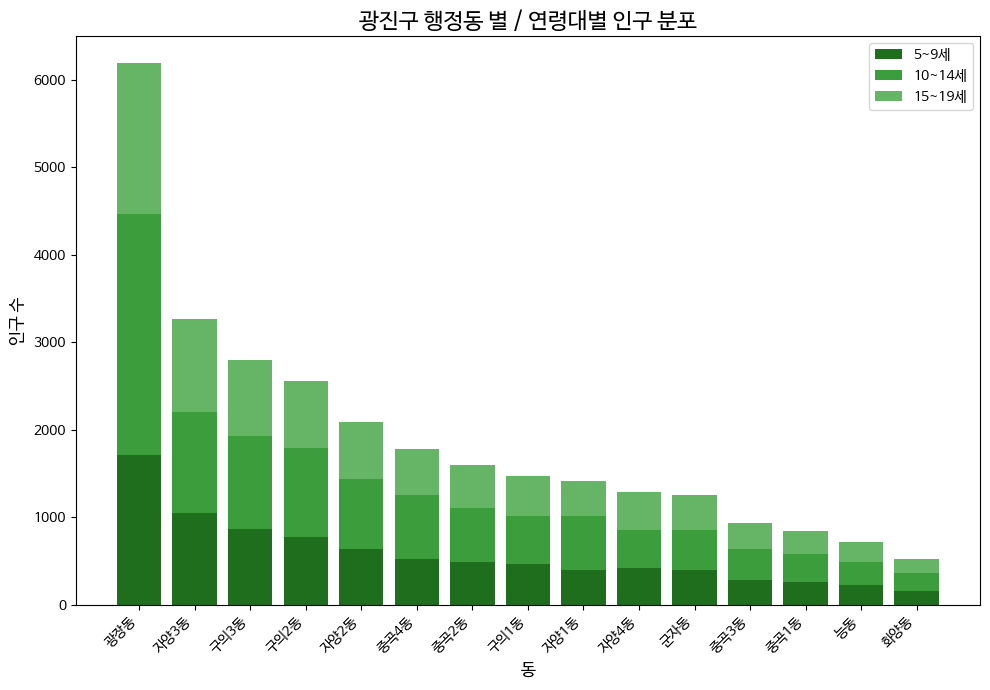

In [ ]:
# @title 광진구 행정동 별 / 연령대별 인구 분포


# 연령대별 인구 합계 계산
age_info2['총합'] = age_info2['5~9세'] + age_info2['10~14세'] + age_info2['15~19세']
age_info2_sorted = age_info2.sort_values(by='총합', ascending=False)

fig, ax = plt.subplots(figsize=(10, 7))

ax.bar(age_info2_sorted['동'], age_info2_sorted['5~9세'], color='#1E6E1E', label='5~9세')
ax.bar(age_info2_sorted['동'], age_info2_sorted['10~14세'], color='#3B9D3B', bottom=age_info2_sorted['5~9세'], label='10~14세')
ax.bar(age_info2_sorted['동'], age_info2_sorted['15~19세'], color='#66B566', bottom=age_info2_sorted['5~9세'] + age_info2_sorted['10~14세'], label='15~19세')

# 타이틀, 레이블 설정
ax.set_title('광진구 행정동 별 / 연령대별 인구 분포', fontsize=16)
ax.set_xlabel('동', fontsize=12)
ax.set_ylabel('인구 수', fontsize=12)
ax.legend()

# X축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 그래프 출력
plt.show()


## 공원 부지

In [ ]:
park_data = pd.read_csv("/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/수연/5광진구_도시공원_정보.csv")
park_data.head()

관리번호    공원명    동 동(세부)   공원구분                    소재지도로명주소  \
0  11215-10533   온달공원  광장동   광장동  어린이공원  서울특별시 광진구 아차산로73길 15 (광장동)   
1  11215-10534   평강공원  광장동   광장동  어린이공원                         NaN   
2  11215-10526  무궁화공원  구의동  구의3동  어린이공원  서울특별시 광진구 광나루로52길 12 (구의동)   
3  11215-10524  개나리공원  구의동  구의3동  어린이공원                         NaN   
4  11215-10525   목련공원  구의동  구의3동  어린이공원  서울특별시 광진구 아차산로59길 49 (구의동)   

                소재지지번주소         위도          경도    공원면적 공원보유시설(운동시설)  \
0   서울특별시 광진구 광장동 242-1  37.545987  127.104076  1012.0          NaN   
1   서울특별시 광진구 광장동 387-1  37.548118  127.100578   325.0          NaN   
2  서울특별시 광진구 구의동 206-10  37.541247  127.094551  1041.7          NaN   
3   서울특별시 광진구 구의동 216-5  37.538013  127.092365   988.8          NaN   
4   서울특별시 광진구 구의동 223-4  37.540640  127.090654   989.8          NaN   

        공원보유시설(유희시설) 공원보유시설(편익시설)  공원보유시설(교양시설) 공원보유시설(기타시설)     지정고시일  \
0  조합놀이대, 그네, 흔들놀이기구          화장실           NaN          경로당  11-14-78   
1                 그네          화장실           NaN          NaN  05-18-84   
2          조합놀이대, 그네          화장실           NaN          NaN  01-21-69   
3      조합놀이대, 흔들놀이기구          NaN           NaN          NaN  01-21-69   
4          조합놀이대, 그네          화장실           NaN          NaN  01-21-69   

        관리기관명         전화번호   데이터기준일자  
0  서울특별시 광진구청  02-450-7778  03-10-25  
1  서울특별시 광진구청  02-450-7778  03-10-25  
2  서울특별시 광진구청  02-450-7775  03-10-25  
3  서울특별시 광진구청  02-450-7775  03-10-25  
4  서울특별시 광진구청  02-450-7775  03-10-25

In [ ]:
park_data_cleaned = park_data[['공원명', '공원면적', '동', '동(세부)', '위도', '경도', '공원면적']]

In [ ]:
park_data_cleaned.describe()

공원면적         위도          경도          공원면적
count     43.000000  43.000000   43.000000     43.000000
mean    1128.609302  37.543754  127.081516   1128.609302
std     1505.276394   0.010356    0.010769   1505.276394
min       95.200000  37.530310  127.061859     95.200000
25%      801.350000  37.535925  127.071140    801.350000
50%      985.900000  37.541424  127.082192    985.900000
75%     1007.150000  37.550279  127.090837   1007.150000
max    10464.000000  37.568341  127.104076  10464.000000

In [ ]:
# @title 지도 위 공원 시각화

# def add_park_circle_markers(map_obj, park_data):
#     for idx, row in park_data.iterrows():
#         radius = row['공원면적'] / 100
#         folium.CircleMarker(
#             location=[row['위도'], row['경도']],
#             radius=radius,
#             color='green',
#             fill=True,
#             fill_color='green',
#             fill_opacity=0.6,
#             popup=row['공원명']
#         ).add_to(map_obj)

#     return map_obj

# map_5_14_with_parks_circles = add_park_circle_markers(map_5_14, park_data_cleaned)

# map_5_14_with_parks_circles

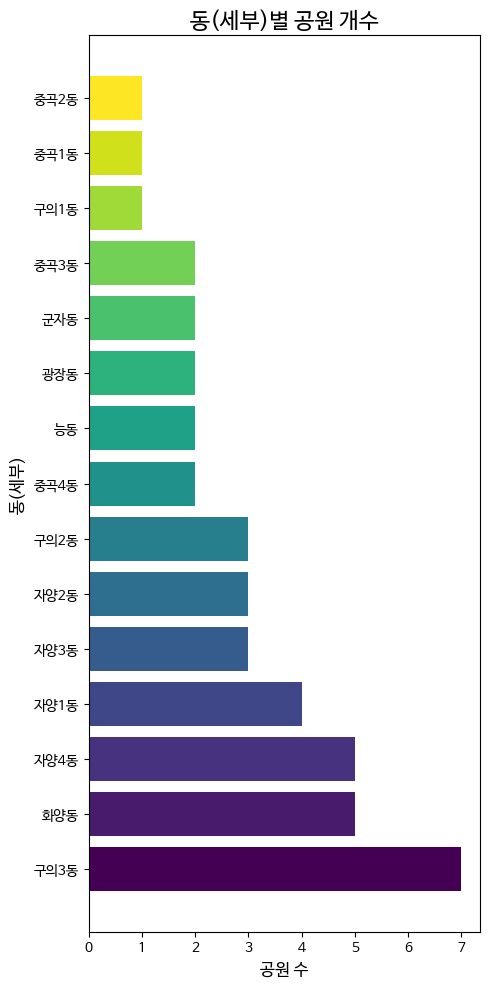

In [ ]:
# @title 동(세부)별 공원 개수

park_count = park_data_cleaned.groupby('동(세부)')["공원명"].count().sort_values(ascending=False).reset_index()
park_count.columns = ["동(세부)", "공원수"]

plt.figure(figsize=(5, 10))
plt.barh(park_count['동(세부)'], park_count['공원수'], color=plt.cm.viridis(np.linspace(0, 1, len(park_count))))

plt.title('동(세부)별 공원 개수', fontsize=16)
plt.xlabel('공원 수', fontsize=12)
plt.ylabel('동(세부)', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# @title 동별 공원 개수

park_count = park_data_cleaned.groupby('동')["공원명"].count().sort_values(ascending=False).reset_index()
park_count.columns = ["동", "공원수"]
park_count

동  공원수
0  자양동   15
1  구의동   11
2  중곡동    6
3  화양동    5
4  광장동    2
5  군자동    2
6   능동    2

## 서울시 공원 개수 비교

In [ ]:
seoul_park_data = pd.read_csv('/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/수연/3전국_도시공원_정보.csv', encoding='cp949')
seoul_park_data['구'] = seoul_park_data['소재지지번주소'].str.split().str[1]
seoul_parks_in_seoul = seoul_park_data[seoul_park_data['소재지지번주소'].str.split().str[0] == '서울특별시']
seoul_parks_in_seoul_data = seoul_parks_in_seoul[['구', '공원명', '위도', '경도', '공원면적']]
seoul_parks_in_seoul_data.head()

구       공원명         위도          경도    공원면적
58  영등포구   산성어린이공원  37.496977  126.902594   413.0
59  영등포구  다사랑어린이공원  37.492834  126.899215  1632.0
60  영등포구  고추말어린이공원  37.511577  126.907051  3071.0
61  영등포구   대림어린이공원  37.491332  126.903016  6969.0
62  영등포구   서강어린이공원  37.525922  126.905848  1797.0

In [ ]:
seoul_park_count = seoul_parks_in_seoul_data.groupby('구')["공원명"].count().sort_values(ascending=False).reset_index()
seoul_park_count.columns = ["구", "공원수"]

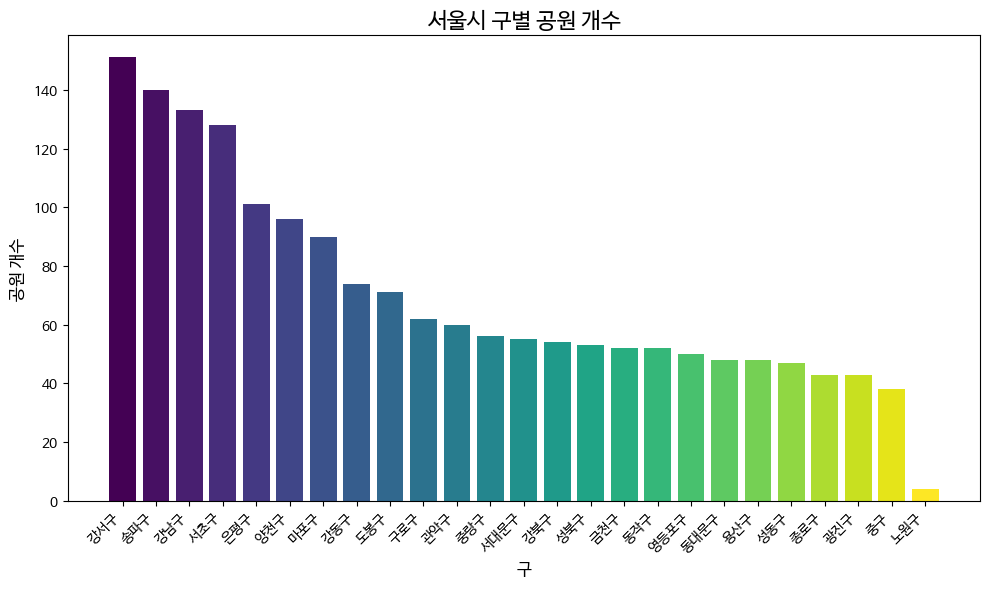

In [ ]:
# @title 지도 시각화

seoul_park_count = seoul_parks_in_seoul_data.groupby('구')["공원명"].count().sort_values(ascending=False).reset_index()
seoul_park_count.columns = ["구", "공원수"]

plt.figure(figsize=(10, 6))
plt.bar(seoul_park_count['구'], seoul_park_count['공원수'], color=plt.cm.viridis(np.linspace(0, 1, len(seoul_park_count))))

plt.title('서울시 구별 공원 개수', fontsize=16)
plt.xlabel('구', fontsize=12)
plt.ylabel('공원 개수', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 격자 분석_초안

In [ ]:
# @title 유소년 인구수 100m

F1 = "/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/1광진구_유소년_인구수_100/nlsp_021001004.shp"
D1 = gpd.read_file(F1, encoding='UTF-8')
D1.loc[D1['val'] >= 240, 'val'] = 230
D1.head(3)

gid    lbl   val                                           geometry
0  다사633494  15.00  15.0  POLYGON ((963300 1949400, 963300 1949500, 9634...
1  다사626517  18.00  18.0  POLYGON ((962600 1951700, 962600 1951800, 9627...
2  다사642512  30.00  30.0  POLYGON ((964200 1951200, 964200 1951300, 9643...

In [ ]:
# @title 공시지가 100m
F2 = "/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/2광진구_공시지가_100/nlsp_021004001.shp"
D2 = gpd.read_file(F2, encoding='UTF-8')
D2.head(1)

gid         lbl         val  \
0  다사629496  5658798.87  5658798.87   

                                            geometry  
0  POLYGON ((962900 1949600, 962900 1949700, 9630...

# 새 섹션

In [ ]:
# @title 생활권공원 서비스권역 내 인구비율 500m
F3 = "/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/3생활권공원_서비스권역_내_인구비율_500/71.1 생활권공원(읍면동) 서비스권역 내 인구비율(0.5km).shp"
D3 = gpd.read_file(F3, encoding='UTF-8')
D3.head(1)

emd_cd emd_nm_k       emd_nm_e sgg_cd sgg_nm_k   sgg_nm_e sido_cd  \
0  11110101      청운동  Cheongun-dong  11110      종로구  Jongno-gu      11   

  sido_nm_k sido_nm_e  cd_fac  cd_range  value_r  stats_year  raw_d_year  \
0     서울특별시     Seoul       1       0.5      0.0        2023      202310   

   pop_year                                           geometry  
0    202310  POLYGON ((953700.022 1954605.065, 953693.871 1...

In [ ]:
# @title 생활권공원 접근성 250m
F4 = "/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/4생활권공원_접근성_250/69.1 생활권공원(읍면동격자) 접근성.shp"
D4 = gpd.read_file(F4, encoding='UTF-8')
D4.head(1)

gid    emd_cd emd_nm_k       emd_nm_e sgg_cd sgg_nm_k   sgg_nm_e  \
0  다사53ab54ab  11110101      청운동  Cheongun-dong  11110      종로구  Jongno-gu   

  sido_cd sido_nm_k sido_nm_e  value  stats_year  raw_d_year  \
0      11     서울특별시     Seoul  1.099        2023      202310   

                                            geometry  
0  POLYGON ((953250 1954250, 953250 1954500, 9535...

In [ ]:
# @title 고령자 인구수 100m
F5 = "/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/5광진구_고령자_인구수_100/nlsp_021001010.shp"
D5 = gpd.read_file(F5, encoding='UTF-8')
D5.head(1)

gid    lbl   val                                           geometry
0  다사633494  47.00  47.0  POLYGON ((963300 1949400, 963300 1949500, 9634...

In [ ]:
D3.describe()

cd_fac  cd_range      value_r  stats_year  raw_d_year  pop_year
count  5065.0    5065.0  5065.000000      5065.0      5065.0    5065.0
mean      1.0       0.5    11.485364      2023.0    202310.0  202310.0
std       0.0       0.0   118.538076         0.0         0.0       0.0
min       1.0       0.5  -999.000000      2023.0    202310.0  202310.0
25%       1.0       0.5     0.000000      2023.0    202310.0  202310.0
50%       1.0       0.5     3.280000      2023.0    202310.0  202310.0
75%       1.0       0.5    46.560000      2023.0    202310.0  202310.0
max       1.0       0.5   100.000000      2023.0    202310.0  202310.0

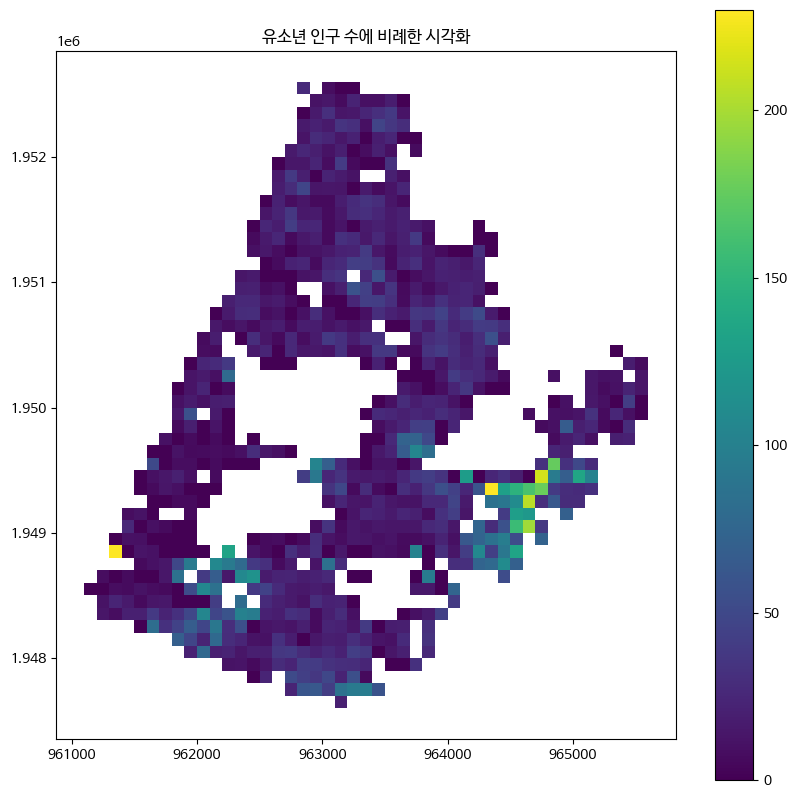

In [ ]:
# @title grid 유소년 인구 분포
fig, ax = plt.subplots(figsize=(10, 10))

# 색상 맵 설정
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=D1['val'].min(), vmax=D1['val'].max())

# 유소년 인구 수에 따라 색상을 다르게 설정하여 시각화
D1.plot(ax=ax, edgecolor="w", column='val', cmap=cmap, linewidth=0.0, legend=True, norm=norm)
plt.title("유소년 인구 수에 비례한 시각화")

plt.show();

In [ ]:
# @title grid 유소년, 지도, 공원

gwangjin_map = folium.Map(location=[37.538, 127.082], tiles='cartodbpositron', zoom_start=13.3)

folium.Choropleth(
    geo_data=D1,
    data=D1,
    columns=['gid', 'val'],
    key_on='feature.properties.gid',
    fill_color='Oranges',
    fill_opacity=0.9,
    line_opacity=0.34,
    nan_fill_color='#758773',
    legend_name='유소년 인구 수'
).add_to(gwangjin_map)

for idx, row in park_data.iterrows():
    folium.Circle(
        location=[row['위도'], row['경도']],  # 위도, 경도
        radius=250,
        color='red',
        weight=0,
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        popup=row['공원명']
    ).add_to(gwangjin_map)

folium.LayerControl().add_to(gwangjin_map)
#여기에다가 레이어를 추가해서 서클로 표시된걸 끄고 킬수 있게 할래

# 결과 지도 출력
gwangjin_map


In [ ]:
# @title 지역아동센터

kid_df = pd.read_csv('/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/서울특별시 광진구_지역아동센터_20250110.csv', encoding='cp949')
kid_df = kid_df[['센터명', '소재지도로명주소', '위도', '경도']]
kid_df.head()

센터명              소재지도로명주소         위도          경도
0  새움터지역아동센터     서울특별시 광진구 자양로71-7  37.534088  127.083882
1   경희지역아동센터   서울특별시 광진구 긴고랑로7길 54  37.565658  127.080422
2  꿈나래지역아동센터       서울특별시 광진구 영화사로9  37.558261  127.088736
3   새날지역아동센터  서울특별시 광진구 아차산로26길 22  37.540443  127.065546
4   새빛지역아동센터     서울특별시 광진구 아차산로330  37.537237  127.079412

In [ ]:
# @title 키즈카페

kid_cafe_df = pd.read_csv('/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/서울형 키즈카페 시설현황정보.csv', encoding='cp949')
kid_cafe_df = kid_cafe_df[['시설명', '기본주소', 'x좌표값', 'y좌표값']]
kid_cafe_df.head()

시설명                  기본주소        x좌표값       y좌표값
0              서울형키즈카페 동대문구 장안1동점  서울특별시 동대문구 답십리로66길 3  127.068590  37.572340
1               서울형키즈카페 동대문구 제기동점  서울특별시 동대문구 약령시로7길 19  127.034670  37.583730
2              서울형 키즈카페 구로구 구로4동점  서울특별시 구로구 구로동로26길 54  126.886570  37.489900
3              서울형 키즈카페 양천구 신월3동점   서울특별시 양천구 남부순환로 374  126.829390  37.533620
4  서울형 키즈카페 강동구 상일2동 2호점(아이?맘 강동)   서울특별시 강동구 고덕로98길 71  127.179806  37.555335

In [ ]:
# @title 유치원

kid_kindergarten_df = pd.read_csv('/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/서울시 유치원 일반현황.csv')
kid_kindergarten_df = kid_kindergarten_df[['유치원명', '주소', '위도', '경도']]
kid_kindergarten_df.head(2)

유치원명                   주소         위도          경도
0  선경유치원  서울특별시 광진구 뚝섬로66길 14  37.533396  127.089785
1  성산유치원  서울특별시 광진구 뚝섬로59길 18  37.532909  127.084178

In [ ]:
# @title 학교

kid_school_df = pd.read_csv('/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/서울시 광진구 학교 기본정보.csv')
kid_school_df = kid_school_df[['학교명', '도로명주소', '위도', '경도']]
kid_school_df.head(2)

학교명               도로명주소         위도          경도
0  세종초등학교   서울특별시 광진구 군자로 114  37.553011  127.072865
1  성동초등학교  서울특별시 광진구 자양로4길 63  37.533281  127.089281

In [ ]:
# @title 주차장

parking_availability = pd.read_csv('/content/drive/MyDrive/공모전/광진구 공모전 데이터/db/수연/12광진구_주차장_현황.csv')
parking_availability = parking_availability[['주차장명', '소재지도로명주소', '위도', '경도']]
parking_availability.head(2)

주차장명 소재지도로명주소  위도  경도
0   송림식당길 노상 공영주차장      NaN NaN NaN
1  동서울호텔길 노상 공영주차장      NaN NaN NaN

## 데이터 정리

In [ ]:
# @title 유소년 인구 수
# 컬럼명 정리
D1 = D1[['gid', 'val']].rename(columns={'val': 'youth_population'})

# 병합
grid_filled = grid_filled.merge(D1, on='gid', how='left')

# 결측값 0으로 처리
grid_filled['youth_population'] = grid_filled['youth_population'].fillna(0)



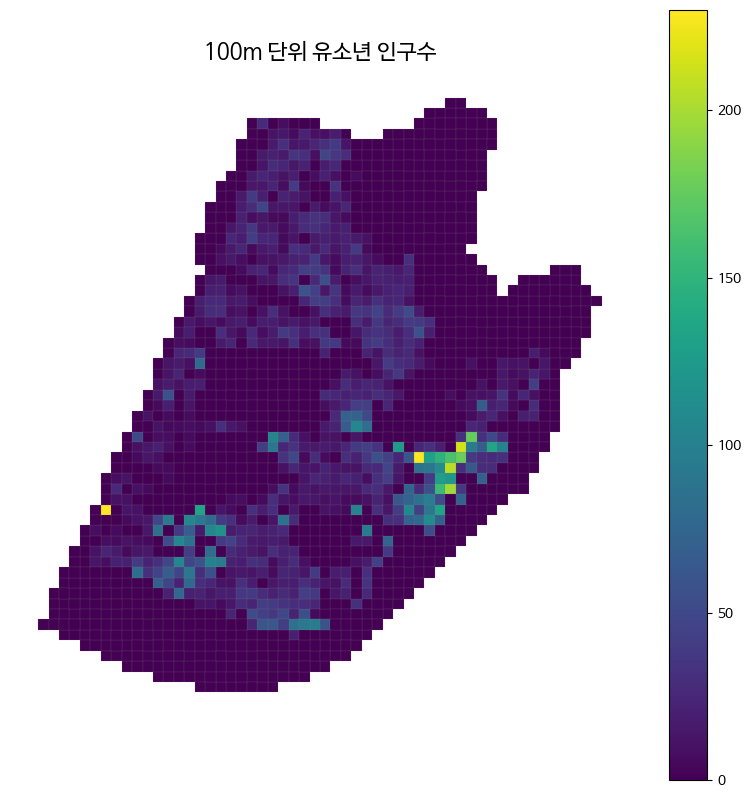

In [ ]:
# @title 유소년 인구 수 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='youth_population',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 유소년 인구수', fontsize=16)
ax.axis('off')
plt.show()


In [ ]:
# @title 공원 접근성
grid_100m = youth_population[['gid', 'geometry']].copy()
access_250m = D4[['value', 'geometry']].copy()
grid_with_access = gpd.sjoin(grid_100m, access_250m, how='left', predicate='within')
grid_with_access = grid_with_access[['gid', 'value', 'geometry']].rename(columns={'value': 'park_accessibility'})

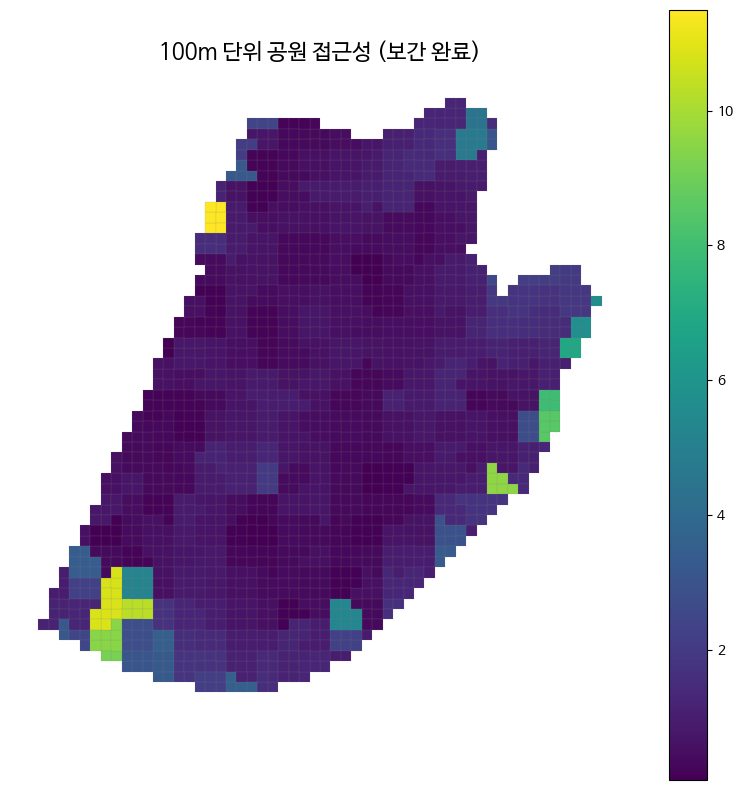

In [ ]:
# @title 공원 접근성 시각화(100m 단위)

from sklearn.neighbors import KDTree
# 복사: 비어 있는 접근성 데이터 찾기
missing = grid_with_access[grid_with_access['park_accessibility'].isna()].copy()
filled = grid_with_access[grid_with_access['park_accessibility'].notna()].copy()

# 중심 좌표 계산
missing['centroid'] = missing.geometry.centroid
filled['centroid'] = filled.geometry.centroid

# 좌표 배열로 변환
missing_coords = np.array([(pt.x, pt.y) for pt in missing.centroid])
filled_coords = np.array([(pt.x, pt.y) for pt in filled.centroid])

# KNN으로 최근접값 찾기
tree = KDTree(filled_coords)
dist, idx = tree.query(missing_coords, k=1)

# 최근접 접근성 값 복사
missing['park_accessibility'] = filled.iloc[idx.flatten()]['park_accessibility'].values

# 다시 합치기
grid_filled = pd.concat([filled, missing], ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(column='park_accessibility', cmap=cmap, linewidth=0.1, edgecolor='gray', legend=True, ax=ax)
ax.set_title('100m 단위 공원 접근성 (보간 완료)', fontsize=16)
ax.axis('off')
plt.show()

In [ ]:
# @title 어린이공원 위치
from shapely.geometry import Point

# 1. 공원 중심 포인트 → GeoDataFrame
park_data_cleaned['geometry'] = park_data_cleaned.apply(
    lambda row: Point(row['경도'], row['위도']),
    axis=1
)
park_gdf = gpd.GeoDataFrame(park_data_cleaned, geometry='geometry', crs='EPSG:4326')
park_gdf = park_gdf.to_crs(grid_filled.crs)

# 2. 100m 격자의 중심 좌표 계산
grid_filled['centroid'] = grid_filled.geometry.centroid

# 3. 거리 기반 영향력 계산
scores = []

for _, grid_row in grid_filled.iterrows():
    max_score = 0
    for _, park_row in park_gdf.iterrows():
        dist = grid_row['centroid'].distance(park_row['geometry'])  # 거리 계산
        if dist <= 300:
            score = (1 - (dist / 300)) ** 2
            max_score = max(max_score, score)
    scores.append(max_score)

# 4. 영향력 컬럼 추가
grid_filled['child_park_score'] = scores
grid_filled = grid_filled.drop(columns='centroid')


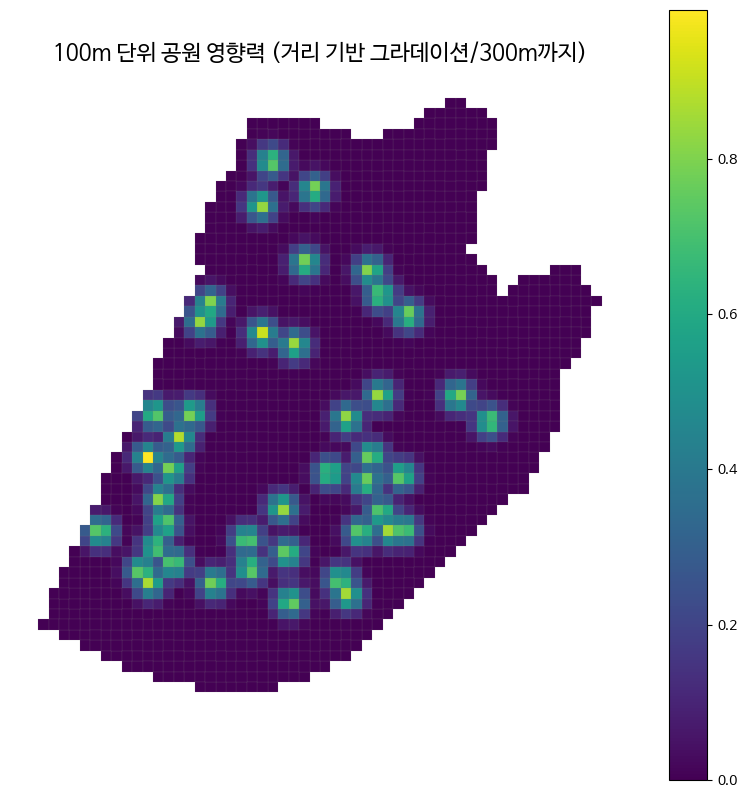

In [ ]:
# @title 어린이공원 위치 시각화(300m 그라데이션)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='child_park_score',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 공원 영향력 (거리 기반 그라데이션/300m까지)', fontsize=16)
ax.axis('off')
plt.show()


In [ ]:
# @title 지역아동센터

# 1. GeoDataFrame으로 변환
kid_df['geometry'] = kid_df.apply(lambda row: Point(row['경도'], row['위도']), axis=1)
kid_gdf = gpd.GeoDataFrame(kid_df, geometry='geometry', crs='EPSG:4326')
kid_gdf = kid_gdf.to_crs(grid_filled.crs)

# 2. 격자 중심 계산
grid_filled['centroid'] = grid_filled.geometry.centroid

# 3. 거리 기반 영향력 계산
kid_scores = []
for _, grid_row in grid_filled.iterrows():
    max_score = 0
    for _, kid_row in kid_gdf.iterrows():
        dist = grid_row['centroid'].distance(kid_row['geometry'])
        if dist <= 300:
            score = (1 - (dist / 300)) ** 2
            max_score = max(max_score, score)
    kid_scores.append(max_score)

# 4. 영향력 컬럼 저장
grid_filled['kid_center_score'] = kid_scores
grid_filled = grid_filled.drop(columns='centroid')


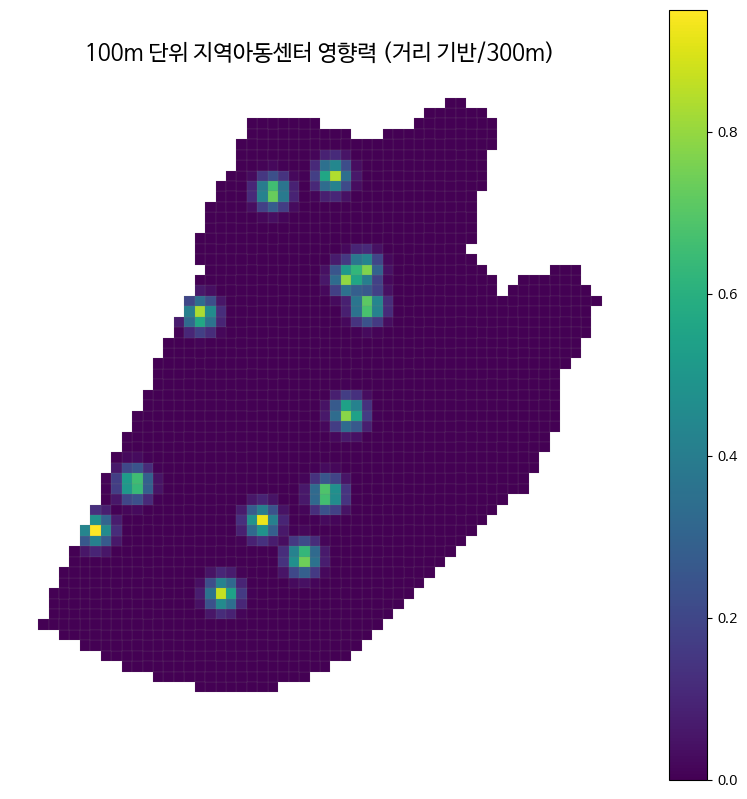

In [ ]:
# @title 지역아동센터 시각화

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='kid_center_score',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 지역아동센터 영향력 (거리 기반/300m)', fontsize=16)
ax.axis('off')
plt.show()


In [ ]:
# @title 유치원

# 1. GeoDataFrame으로 변환
kid_kindergarten_df['geometry'] = kid_kindergarten_df.apply(
    lambda row: Point(row['경도'], row['위도']), axis=1
)
kindergarten_gdf = gpd.GeoDataFrame(kid_kindergarten_df, geometry='geometry', crs='EPSG:4326')
kindergarten_gdf = kindergarten_gdf.to_crs(grid_filled.crs)

# 2. 격자 중심 계산
grid_filled['centroid'] = grid_filled.geometry.centroid

# 3. 거리 기반 영향력 계산
kindergarten_scores = []
for _, grid_row in grid_filled.iterrows():
    max_score = 0
    for _, kinder_row in kindergarten_gdf.iterrows():
        dist = grid_row['centroid'].distance(kinder_row['geometry'])
        if dist <= 300:
            score = (1 - (dist / 300)) ** 2
            max_score = max(max_score, score)
    kindergarten_scores.append(max_score)

# 4. 영향력 컬럼 저장
grid_filled['kindergarten_score'] = kindergarten_scores
grid_filled = grid_filled.drop(columns='centroid')



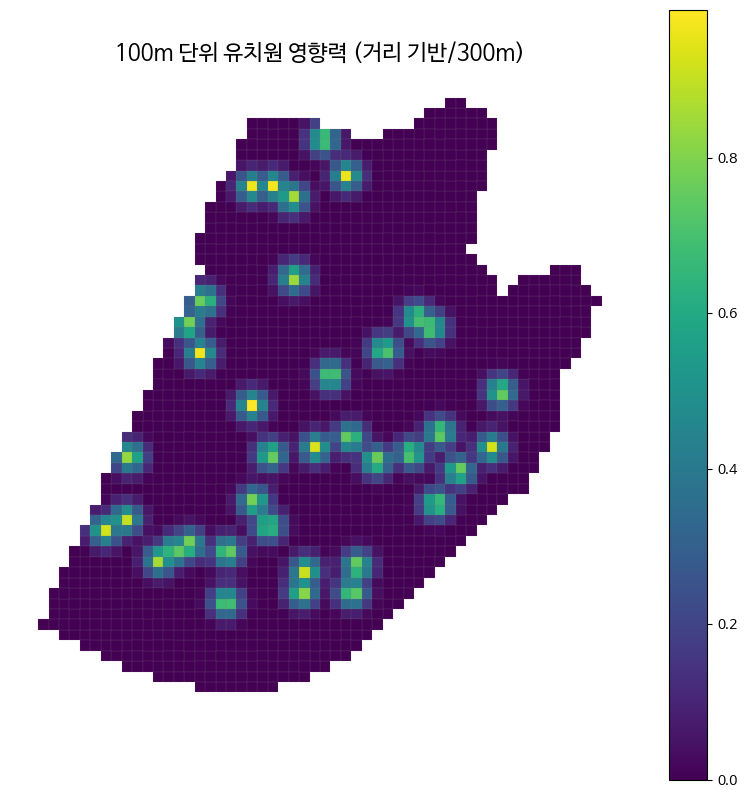

In [ ]:
# @title 유치원 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='kindergarten_score',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 유치원 영향력 (거리 기반/300m)', fontsize=16)
ax.axis('off')
plt.show()


In [ ]:
# @title 학교

# 1. GeoDataFrame으로 변환
kid_school_df['geometry'] = kid_school_df.apply(
    lambda row: Point(row['경도'], row['위도']), axis=1
)
school_gdf = gpd.GeoDataFrame(kid_school_df, geometry='geometry', crs='EPSG:4326')
school_gdf = school_gdf.to_crs(grid_filled.crs)

# 2. 격자 중심 계산
grid_filled['centroid'] = grid_filled.geometry.centroid

# 3. 거리 기반 영향력 계산
school_scores = []
for _, grid_row in grid_filled.iterrows():
    max_score = 0
    for _, school_row in school_gdf.iterrows():
        dist = grid_row['centroid'].distance(school_row['geometry'])
        if dist <= 300:
            score = (1 - (dist / 300)) ** 2
            max_score = max(max_score, score)
    school_scores.append(max_score)

# 4. 영향력 컬럼 저장
grid_filled['school_score'] = school_scores
grid_filled = grid_filled.drop(columns='centroid')


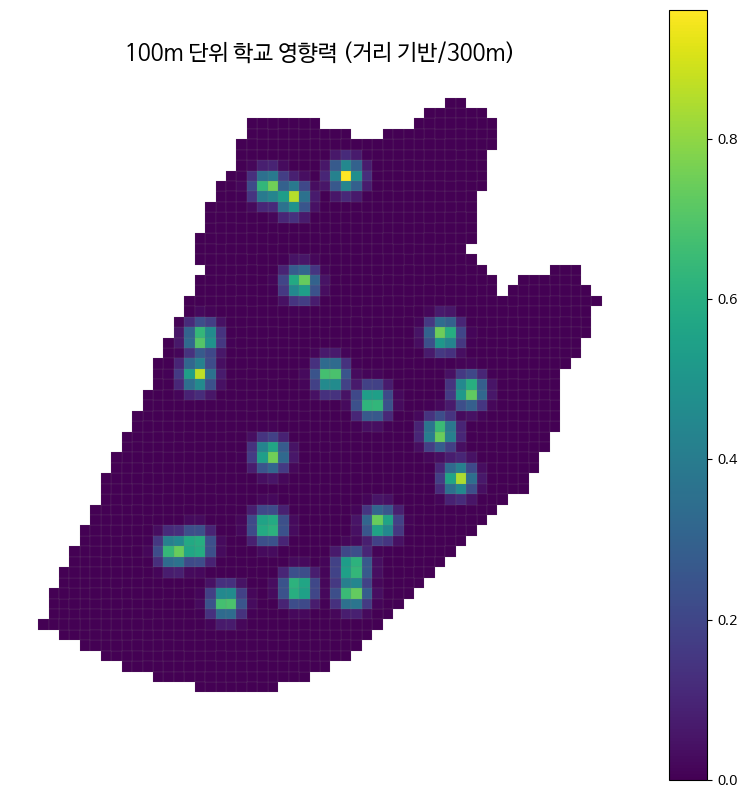

In [ ]:
# @title 학교 시각화

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='school_score',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 학교 영향력 (거리 기반/300m)', fontsize=16)
ax.axis('off')
plt.show()


In [ ]:
# @title 키즈카페

# 1. GeoDataFrame으로 변환
kid_cafe_df['geometry'] = kid_cafe_df.apply(
    lambda row: Point(row['x좌표값'], row['y좌표값']),
    axis=1
)
cafe_gdf = gpd.GeoDataFrame(kid_cafe_df, geometry='geometry', crs='EPSG:4326')
cafe_gdf = cafe_gdf.to_crs(grid_filled.crs)

# 2. 격자 중심 계산
grid_filled['centroid'] = grid_filled.geometry.centroid

# 3. 거리 기반 영향력 계산
cafe_scores = []
for _, grid_row in grid_filled.iterrows():
    max_score = 0
    for _, cafe_row in cafe_gdf.iterrows():
        dist = grid_row['centroid'].distance(cafe_row['geometry'])
        if dist <= 300:
            score = (1 - (dist / 300)) ** 2
            max_score = max(max_score, score)
    cafe_scores.append(max_score)

# 4. 영향력 컬럼 저장
grid_filled['kids_cafe_score'] = cafe_scores
grid_filled = grid_filled.drop(columns='centroid')


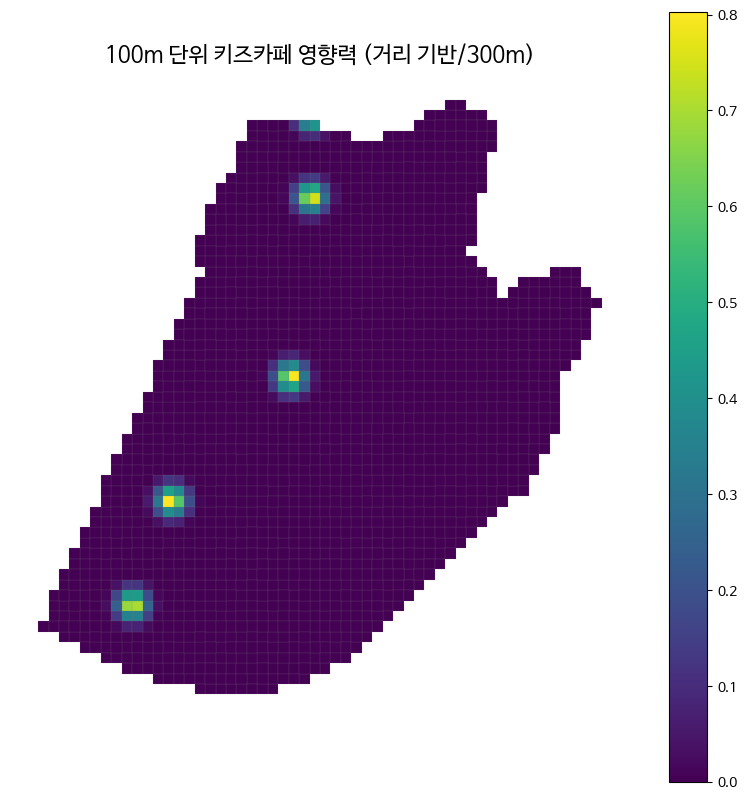

In [ ]:
# @title 키즈카페 시각화

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='kids_cafe_score',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 키즈카페 영향력 (거리 기반/300m)', fontsize=16)
ax.axis('off')
plt.show()


In [ ]:
# @title 고령자 인구
D5 = D5[['gid', 'val', 'geometry']].rename(columns={'val': 'elderly_population'})

# 좌표계 통일
D5 = D5.to_crs(grid_filled.crs)

# geometry 기준 병합
grid_filled = grid_filled.merge(D5[['gid', 'elderly_population']], on='gid', how='left')

# 결측치 0으로 채우기
grid_filled['elderly_population'] = grid_filled['elderly_population'].fillna(0)


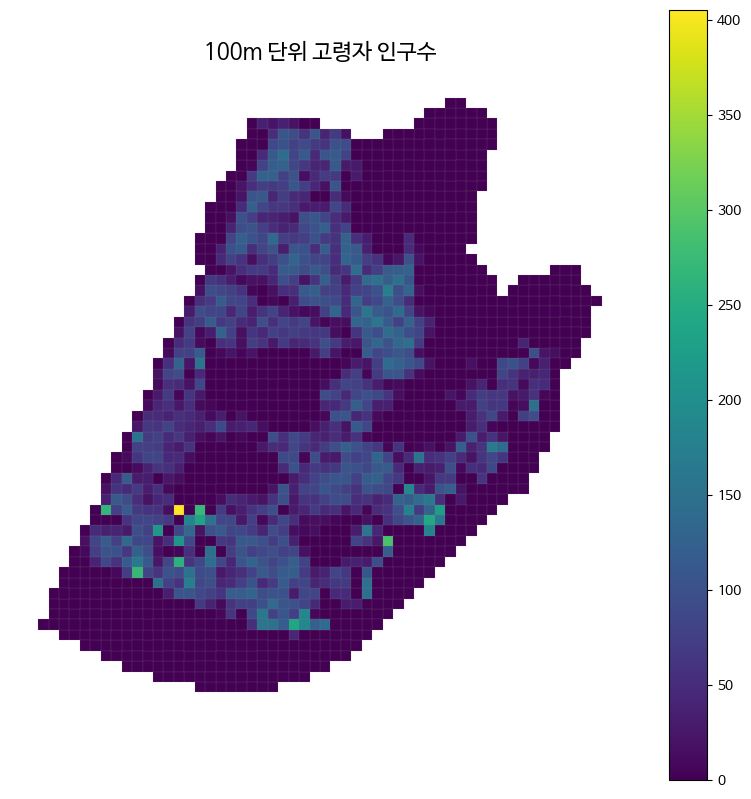

In [ ]:
# @title 고령자 인구 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='elderly_population',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 고령자 인구수', fontsize=16)
ax.axis('off')
plt.show()


In [ ]:
# @title 공시지가

D2 = D2[['gid', 'val']].rename(columns={'val': 'land_price'})

# 병합
grid_filled = grid_filled.merge(D2, on='gid', how='left')

# 결측값 처리
grid_filled['land_price'] = grid_filled['land_price'].fillna(0)


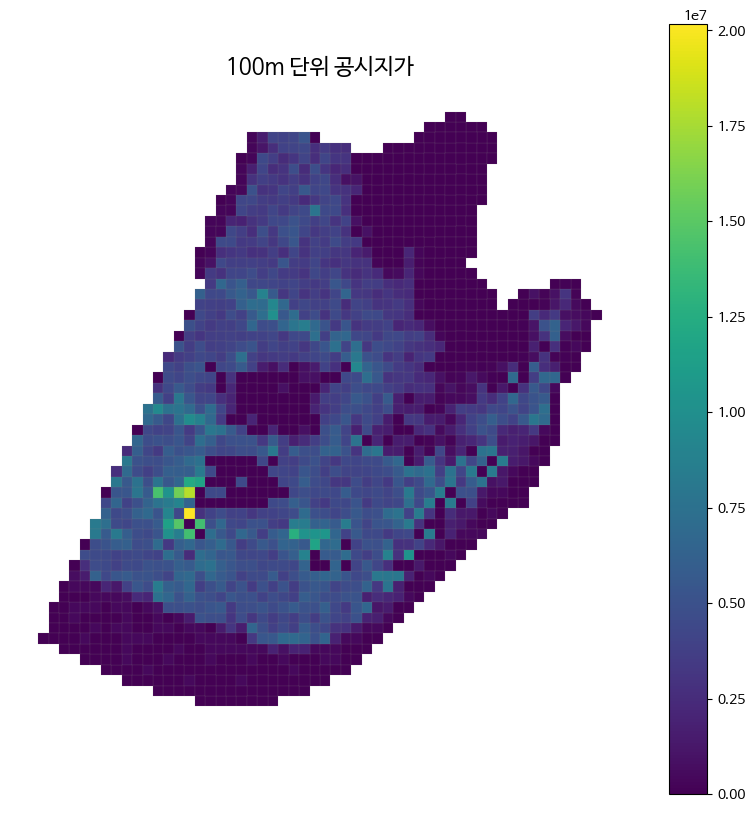

In [ ]:
# @title 공시지가 시각화

#산출방식(단위)	평균(원/㎡)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='land_price',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 공시지가', fontsize=16)
ax.axis('off')
plt.show()


In [ ]:
# @title 주차장
# NaN 제거
parking_availability = parking_availability.dropna(subset=['위도', '경도'])

# GeoDataFrame 변환
parking_availability['geometry'] = parking_availability.apply(
    lambda row: Point(row['경도'], row['위도']), axis=1
)
parking_gdf = gpd.GeoDataFrame(parking_availability, geometry='geometry', crs='EPSG:4326')
parking_gdf = parking_gdf.to_crs(grid_filled.crs)

# 격자 중심 계산
grid_filled['centroid'] = grid_filled.geometry.centroid

# 거리 기반 영향력 계산
parking_scores = []
for _, grid_row in grid_filled.iterrows():
    max_score = 0
    for _, park_row in parking_gdf.iterrows():
        dist = grid_row['centroid'].distance(park_row['geometry'])
        if dist <= 300:
            score = (1 - (dist / 300)) ** 2
            max_score = max(max_score, score)
    parking_scores.append(max_score)

# 영향력 컬럼 저장
grid_filled['parking_score'] = parking_scores
grid_filled = grid_filled.drop(columns='centroid')


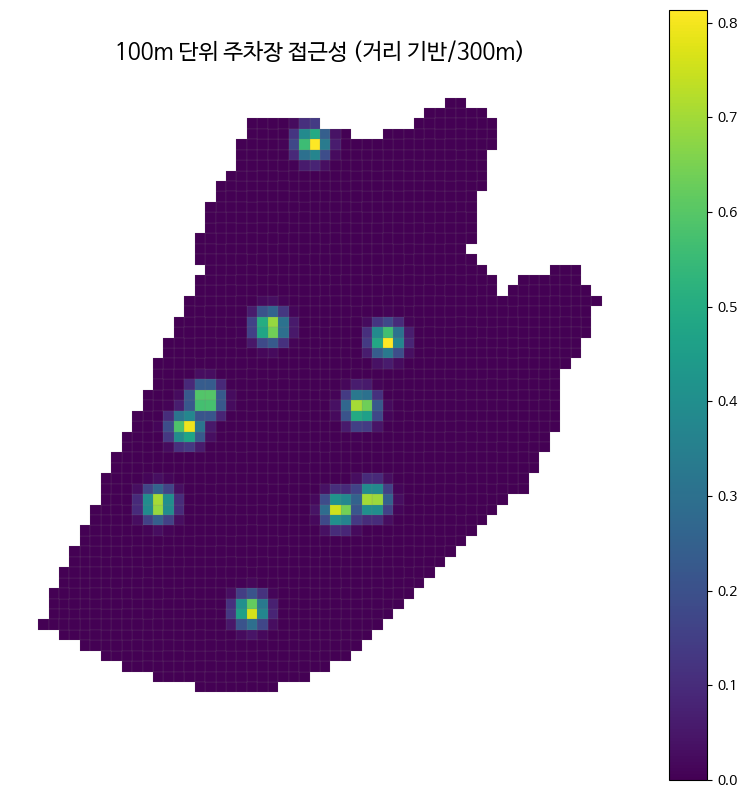

In [ ]:
# @title 주차장 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grid_filled.plot(
    column='parking_score',
    cmap=cmap,
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    ax=ax
)
ax.set_title('100m 단위 주차장 접근성 (거리 기반/300m)', fontsize=16)
ax.axis('off')
plt.show()
